In [1]:
import math  as m
import numpy as np

# liczby losowe
import random

# grafika do wykresów
import matplotlib.pyplot as plt
import matplotlib as mpl

# działania na łańcuchach znaków"
import string 

# statystyka
import statistics as st

# pomar czasu
import time

# dopasowywanie krzywych do danych
from scipy.optimize import curve_fit

# wyświetlanie importowanej grafiki
from IPython.display import display, Image

# wykresy konturowe
import matplotlib.cm as cm

In [2]:
def plot_net(n_war):
    """Narysuj szkielet sieci"""
    li_war=len(n_war)
    plt.figure(figsize=(7,4)) # rozmiar rysunku

    for i in range(li_war): # pętla po warstwach
        for j in range(1,n_war[i]): # pętla po węzłach innych niż progowe w warstwie (zaczynamy od 1)
            plt.scatter(i, j-n_war[i]/2, s=100,c='blue') 
            # rysuj punkt o współrzędnej poziomej i oraz współrzędnej pionowej rosnącej z j 
            # odjęcie n_war[i]/2 powoduje, że średnie pionowe połozenie punktów jest 0
        
    for i in range(li_war-1): # pętla po warstwach z wyjatkiem outputowej
            plt.scatter(i, 0-n_war[i]/2, s=100,c='gray') # dodaj węzły progowe innym kolorem
    
    for i in range(li_war-1): # pętla po warstwach z wyjątkim ostatniej
        for j in range(n_war[i]): # pętla po węzłach, z których wychodzi krawędź
            for k in range(n_war[i+1]-1):  # pętla po węzłach z kolejnej wartwy, do których wchodzi krawędź
                plt.plot([i,i+1],[j-n_war[i]/2,k+1-n_war[i+1]/2],c='gray') # rysowanie krawędzi
                # współrzędne odpowiadają współrzędnym punktu

    plt.title("Sieć o inpucie i " + str(li_war-1)+" warstwach",fontsize=16)

    plt.axis("off")
    plt.show()
    

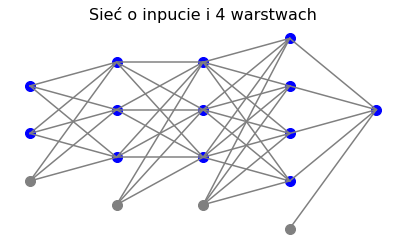

In [3]:
plot_net([3,4,4,5,2])

In [4]:
def plot_net_w(n_war, wagi):
    """Narysuj sieć z wagami"""
    li_war=len(n_war)
    plt.figure(figsize=(7,4)) # rozmiar rysunku

    for i in range(li_war): # pętla po warstwach
        for j in range(1,n_war[i]): # pętla po węzłach innych niż progowe w warstwie (zaczynamy od 1)
            plt.scatter(i, j-n_war[i]/2, s=100,c='blue') 
            # rysuj punkt o współrzędnej poziomej i oraz współrzędnej pionowej rosnącej z j 
            # odjęcie n_war[i]/2 powoduje, że średnie pionowe połozenie punktów jest 0
        
    for i in range(li_war-1): # pętla po warstwach z wyjatkiem outputowej
            plt.scatter(i, 0-n_war[i]/2, s=100,c='gray') # dodaj węzły progowe innym kolorem
    
    li_par=0 #liczba wag
    
    for i in range(li_war-1):
        for j in range(n_war[i]):
            for k in range(n_war[i+1]-1):
                li_par+=1
                th=3*wagi[i+1][j][k]
                if th>0:
                    col='red'
                else:
                    col='blue'
                th=abs(th)
                plt.plot([i,i+1],[j-n_war[i]/2,k+1-n_war[i+1]/2],c=col,linewidth=th)
                

    plt.title("Sieć o inpucie i "+str(li_war-1)+" warstwach (liczba wag: "+str(li_par)+")",fontsize=16)

    plt.axis("off")
    plt.show()

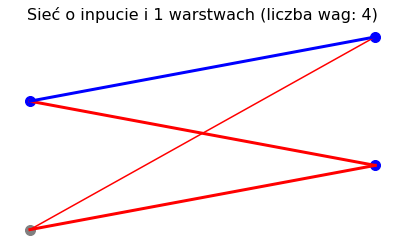

In [5]:
plot_net_w([2,3],{1:[[1,.5],[1,-1]]})

In [6]:
def rn():
    return random.random()-0.5
def ran_w(n_war):
    li_war=len(n_war) 
    wa={}
    for k in range(len(n_war)-1):
        wa.update({k+1: [[rn() for i in range(n_war[k+1]-1)] for j in range(n_war[k])]})
    return wa
def ran_w_s(n_war,s):
    li_war=len(n_war) 
    wa={}
    for k in range(len(n_war)-1):
        wa.update({k+1: [[s*rn() for i in range(n_war[k+1]-1)] for j in range(n_war[k])]})
    return wa

In [7]:
def back_prop(dane, odp, p, n_war, wagi, eps):
    """Propagacja wsteczna"""

# dane - dane szkoleniowe:    
# tablica o liczbie kolumn = liczba węzłów w warstwie inputowej  -1 (nie liczymy węzłą progowego)
#                i liczie wierszy = liczbie punktów danych

# odp - poprawne odpowiedzi
# tablica o liczbie kolumn = liczba węzłów w warstwie outputowej -1 (nie liczymy węzłą progowego)
#                i liczbie wierszy = liczbie punktów danych

# p=0,1, ..., liczba danych-1 - numer punktu w próbce danych szkoleniowych

# n_war - tablica liczby węzłów w kolejnych warstwach od inputu poprzez pośrednie do outputu

    li_war=len(n_war) # liczba warstw (licząc wszystkie)

    po=np.insert(dane[p],0,1) # dodanie do punktu danych jedynki na początku (węzeł progowy)

    x=feed_forward_sig(n_war,wagi,po) # propagacja sygnału do przodu z sigmoidem
   
    n=n_war[li_war-1]-1  # liczba neuronów w warstwie outputowej 
    
    k=len(n_war)-2       # liczba warstw pośrednich
                         # wszystkich warstw jest k+2, są numerowane jako 0,1,2,...,k+1
                         # tj. 0 - inputowa, k+1 - outputowa, pozostałe pośrednie

    D={}                 # słownik dla wielkości D z wyprowadzenia
    
    D.update({k+1:       # D[k+1] - dla warstwy outputowej
        [2*(x[k+1][gam]-odp[p][gam-1])*dsig(np.dot(x[k],wagi[k+1]))[gam-1] for gam in range(1,n+1)]})   

    wagi[k+1]-=eps*np.outer(x[k],D[k+1]) # uaktualnienie wag prowadzących do warstwy outputowej
    
    # pętla po pozostałych warstwach po j = k, k-1, ..., 1
    for j in reversed(range(1,k+1)):            # pętla w odwrotnej kolejności
        u=np.delete(np.dot(wagi[j+1],D[j+1]),0) # implementacja wzoru z wyprowadzena
        v=dsig(np.dot(x[j-1],wagi[j]))          # ...
        D.update({j: [u[i]*v[i] for i in range(len(u))]}) # dopisanie D[j] do słownika
        wagi[j]-=eps*np.outer(x[j-1],D[j])      # uaktualnienie wag

In [8]:
def sig(s):
    return 1/(1+np.exp(-s))

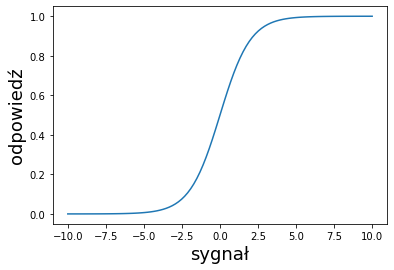

In [9]:
s = np.linspace(-10, 10, 100)

fs = [sig(z) for z in s]

plt.xlabel('sygnał',fontsize=18)
plt.ylabel('odpowiedź',fontsize=18)

plt.plot(s, fs);

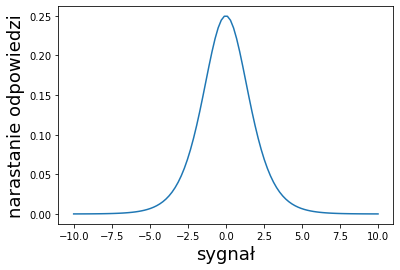

In [10]:
def dsig(s):
     return sig(s)*(1-sig(s)) # szczególna cecha tej funkcji
    
s = np.linspace(-10, 10, 100)
dfs = [dsig(z) for z in s]

plt.xlabel('sygnał',fontsize=18)
plt.ylabel('narastanie odpowiedzi',fontsize=18)

plt.plot(s, dfs);

In [11]:
def feed_forward_sig(n_war, wagi, x_in):
    """Propagacja sygnału w przód"""
    li_war=len(n_war)
    
    x={} # słownik, który będzie zawierać warości sygnałów we wszystkich warstwach
    x.update({0: np.array(x_in)}) 
    
    for i in range(1,li_war): # pętla po warstwach począwszy od pierwszej po inpucie
        a=np.dot(x[i-1],wagi[i]) # sygnał docierający do warstwy i
        b=[sig(a[q]) for q in range(len(a))] # sygnał wychodzacy z warstwy (określony przez funkcję aktywacji)
        x.update({i: np.insert(b,0,1)}) # dopisanie do słownika po wstawieniu sygnału 1 dla węzła progowego
        
    return x

In [12]:
def kwadrat():
    x1=random.random()
    x2=random.random()
    if(0.05 < (x1-0.75)*(x1-0.25))+(x2-0.75)*(x2-0.25) < 0.05:
        return np.array([x1,x2,1])
    else:                           
        return np.array([x1,x2,0])

In [13]:
kwadrat()

array([0.17468186, 0.20343056, 1.        ])

In [14]:
probka_k=np.array([kwadrat() for i in range(3000)])
da_k=np.delete(probka_k,2,1)
od_k=np.delete(np.delete(probka_k,0,1),0,1)

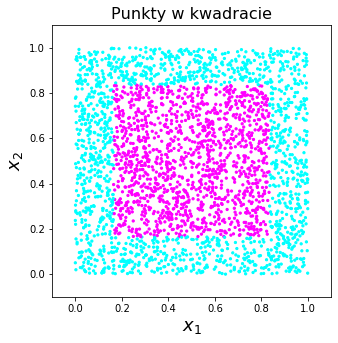

In [15]:
plt.figure(figsize=(5,5))
plt.title("Punkty w kwadracie",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(probka_k[:,0],probka_k[:,1],c=probka_k[:,2],
            s=5,cmap=mpl.cm.cool,norm=mpl.colors.Normalize(vmin=0, vmax=.9))

plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);

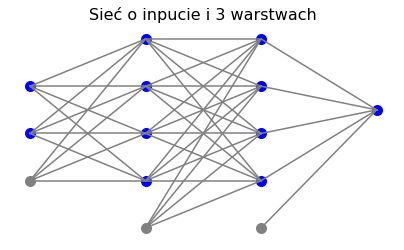

In [16]:
# sieć o dość pokaźnej liczbie neuronów
siec=[3,5,5,2]
plot_net(siec)

wagi=ran_w_s(siec,5.); # początkowe losowe wagi

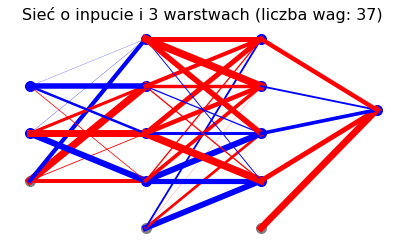

In [17]:
plot_net_w(siec,wagi)